# Desafío 3 - Modelo de lenguaje

## Paola Cartalá

In [1]:
# librerias
import random
import io
import pickle
import json
import os
import re
import glob

import PyPDF2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, SimpleRNN, Embedding, Dropout, TimeDistributed
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.utils import pad_sequences
from scipy.special import softmax

## Carga y Exploración del Dataset

In [2]:
def extraer_texto_pdf(pdf_path):
    """
    Extrae texto de un archivo PDF
    """
    texto_completo = ""
    try:
        with open(pdf_path, 'rb') as file:
            pdf_reader = PyPDF2.PdfReader(file)
            for page in pdf_reader.pages:
                texto_completo += page.extract_text() + "\n"
    except Exception as e:
        print(f"Error al leer {pdf_path}: {e}")
    return texto_completo

In [3]:
pdf_files = glob.glob('data/*.pdf')
print("Corpus disponible:")
for file in pdf_files:
    print(f"- {file}")

corpus_libros = {}
total_caracteres = 0
total_palabras = 0

for pdf_file in pdf_files:
    print(f"\nProcesando: {pdf_file}")
    texto = extraer_texto_pdf(pdf_file)
    
    texto_limpio = texto.replace('\n', ' ').replace('\t', ' ')
    texto_limpio = re.sub(r'\s+', ' ', texto_limpio).strip()
    
    nombre_libro = pdf_file.replace('data/', '').replace('.pdf', '')
    corpus_libros[nombre_libro] = texto_limpio
    
    caracteres = len(texto_limpio)
    palabras = len(texto_limpio.split())
    total_caracteres += caracteres
    total_palabras += palabras
    
corpus_final = " ".join(corpus_libros.values())
print(f"\nCorpus final combinado: {len(corpus_final):,} caracteres")

Corpus disponible:
- data\Ajuste de cuentas - John Grisham.pdf
- data\La lista del juez - John Grisham.pdf
- data\Los adversarios - John Grisham.pdf
- data\Los chicos de Biloxi - John Grisham.pdf

Procesando: data\Ajuste de cuentas - John Grisham.pdf

Procesando: data\La lista del juez - John Grisham.pdf

Procesando: data\Los adversarios - John Grisham.pdf

Procesando: data\Los chicos de Biloxi - John Grisham.pdf

Corpus final combinado: 3,000,247 caracteres


## Preprocesamiento del Texto

### Limpieza del Texto

In [4]:
def limpiar_texto(texto):
    """
    Aplica limpieza avanzada al texto extraído de PDF
    """
    texto = re.sub(r'[\x00-\x1f\x7f-\x9f]', '', texto)
    texto = re.sub(r'\b\d+\b(?:\s+\b\d+\b)*(?=\s|$)', '', texto)
    texto = re.sub(r'([a-záéíóúñ])([.!?])', r'\1 \2', texto, flags=re.IGNORECASE)
    texto = re.sub(r'\s+', ' ', texto)
    texto = texto.lower()
    return texto.strip()

In [5]:
corpus_limpio = limpiar_texto(corpus_final)

print(f"Caracteres después de limpieza: {len(corpus_limpio):,}")
print(f"Reducción: {len(corpus_final) - len(corpus_limpio):,} caracteres")

corpus_final = corpus_limpio

Caracteres después de limpieza: 3,029,137
Reducción: -28,890 caracteres


### Tokenización por Palabras

In [6]:
delimiters = r'(?<=[.,!?]) +'
oraciones = re.split(delimiters, corpus_final)
oraciones = [oracion.strip() for oracion in oraciones if oracion.strip()]

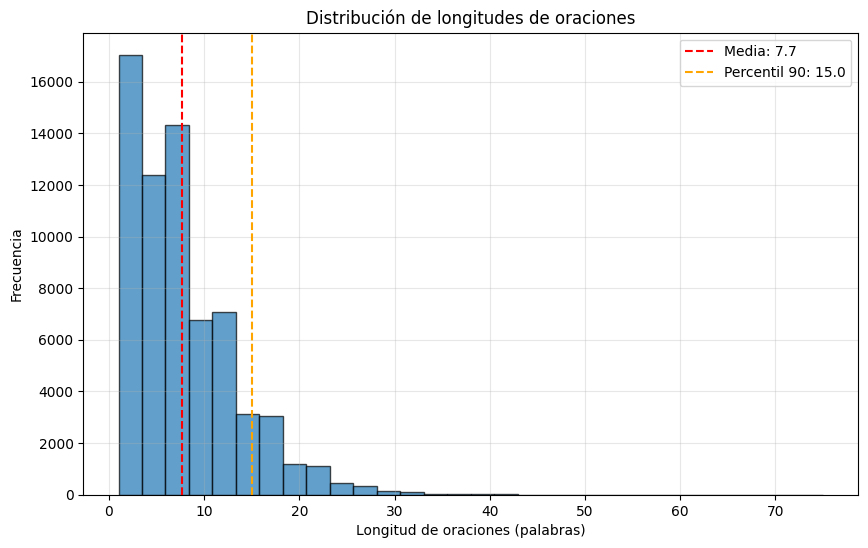

In [7]:
oraciones_segmentadas = [text_to_word_sequence(oracion) for oracion in oraciones]
longitudes = [len(oracion) for oracion in oraciones_segmentadas]

plt.figure(figsize=(10, 6))
plt.hist(longitudes, bins=30, alpha=0.7, edgecolor='black')
plt.xlabel('Longitud de oraciones (palabras)')
plt.ylabel('Frecuencia')
plt.title('Distribución de longitudes de oraciones')
plt.axvline(np.mean(longitudes), color='red', linestyle='--', label=f'Media: {np.mean(longitudes):.1f}')
plt.axvline(np.percentile(longitudes, 90), color='orange', linestyle='--', label=f'Percentil 90: {np.percentile(longitudes, 90):.1f}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [8]:
max_context_size = 15
print(f"Tamaño de contexto optimizado: {max_context_size}")

Tamaño de contexto optimizado: 15


In [9]:
temp_tokenizer = Tokenizer(oov_token="<UNK>")
temp_tokenizer.fit_on_texts(oraciones_segmentadas)

frecuencias = list(temp_tokenizer.word_counts.values())
vocab_completo = len(temp_tokenizer.word_index) + 1

print(f"📊 ANÁLISIS DEL VOCABULARIO COMPLETO:")
print(f"   • Vocabulario total: {vocab_completo:,} palabras")
print(f"   • Palabra más frecuente: {max(frecuencias):,} apariciones")
print(f"   • Palabras con 1 aparición: {sum(1 for f in frecuencias if f == 1):,}")
print(f"   • Palabras con 2-5 apariciones: {sum(1 for f in frecuencias if 2 <= f <= 5):,}")
print(f"   • Palabras con >10 apariciones: {sum(1 for f in frecuencias if f > 10):,}")

📊 ANÁLISIS DEL VOCABULARIO COMPLETO:
   • Vocabulario total: 32,064 palabras
   • Palabra más frecuente: 26,953 apariciones
   • Palabras con 1 aparición: 14,611
   • Palabras con 2-5 apariciones: 10,202
   • Palabras con >10 apariciones: 4,397


In [10]:
estrategias = {
    'conservador': 8000,    # ~80% cobertura
    'moderado': 12000,      # ~90% cobertura 
    'agresivo': 20000,      # ~95% cobertura
    'completo': vocab_completo  # 100% cobertura
}

VOCAB_SIZE = estrategias['conservador']

In [11]:
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<UNK>")
tokenizer.fit_on_texts(oraciones_segmentadas)

oraciones_filtradas = []
for oracion in oraciones_segmentadas:
    if 3 <= len(oracion) <= 20:
        palabras_alpha = sum(1 for palabra in oracion if palabra.isalpha())
        if palabras_alpha / len(oracion) > 0.7:
            oraciones_filtradas.append(oracion)

secuencias_tokenizadas = tokenizer.texts_to_sequences(oraciones_filtradas)

vocab_size = min(len(tokenizer.word_index) + 1, VOCAB_SIZE + 1)

In [12]:
secuencias_temp = tokenizer.texts_to_sequences(oraciones_filtradas[:1000])
total_tokens_muestra = sum(len(seq) for seq in secuencias_temp)
unk_tokens_muestra = sum(seq.count(1) for seq in secuencias_temp)
porcentaje_unk_estimado = (unk_tokens_muestra / total_tokens_muestra * 100) if total_tokens_muestra > 0 else 0

print(f"   • <UNK> tokens estimados: {porcentaje_unk_estimado:.1f}%")
print(f"   • Palabras más frecuentes: {list(tokenizer.word_index.items())[:10]}")

   • <UNK> tokens estimados: 7.5%
   • Palabras más frecuentes: [('<UNK>', 1), ('de', 2), ('y', 3), ('la', 4), ('que', 5), ('a', 6), ('el', 7), ('en', 8), ('se', 9), ('un', 10)]


## Estructura del Dataset

### División en Entrenamiento y Validación

In [13]:
train_seqs, val_seqs = train_test_split(secuencias_tokenizadas, test_size=0.2, random_state=42)

print(f"Secuencias de entrenamiento: {len(train_seqs)}")
print(f"Secuencias de validación: {len(val_seqs)}")

Secuencias de entrenamiento: 41801
Secuencias de validación: 10451


In [14]:
def preparar_secuencias(secuencias, max_context_size):
    """
    Prepara las secuencias para el entrenamiento del modelo de lenguaje.
    Crea múltiples ejemplos a partir de cada secuencia.
    """
    X_data = []
    y_data = []
    
    for seq in secuencias:
        if len(seq) > max_context_size + 1:
            for i in range(len(seq) - max_context_size):
                X_data.append(seq[i:i+max_context_size])
                y_data.append(seq[i+max_context_size])
        elif len(seq) > 1:
            for i in range(1, len(seq)):
                x_seq = seq[:i]
                if len(x_seq) <= max_context_size:
                    x_padded = [0] * (max_context_size - len(x_seq)) + x_seq
                    X_data.append(x_padded)
                    y_data.append(seq[i])
    
    return np.array(X_data), np.array(y_data)

X_train, y_train = preparar_secuencias(train_seqs, max_context_size)
X_val, y_val = preparar_secuencias(val_seqs, max_context_size)

print(f"Forma del dataset de entrenamiento: X={X_train.shape}, y={y_train.shape}")
print(f"Forma del dataset de validación: X={X_val.shape}, y={y_val.shape}")

Forma del dataset de entrenamiento: X=(271654, 15), y=(271654,)
Forma del dataset de validación: X=(67980, 15), y=(67980,)


## Definición de Modelos

### Callback para Perplejidad

In [15]:
class PerplexityCallback(keras.callbacks.Callback):
    """
    Callback para calcular perplejidad durante entrenamiento
    Con early stopping basado en perplejidad
    """
    def __init__(self, validation_data, patience=5, min_delta=0.01):
        super().__init__()
        self.val_data = validation_data[0]  # X_val
        self.val_targets = validation_data[1]  # y_val
        self.patience = patience
        self.min_delta = min_delta
        self.wait = 0
        self.best_val_perplexity = float('inf')
        self.best_weights = None
        
    def on_epoch_end(self, epoch, logs=None):
        # perplejidad de entrenamiento
        train_loss = logs.get('loss')
        if train_loss:
            train_perplexity = np.exp(train_loss)
            logs['perplexity'] = train_perplexity
            
        # perplejidad de validación
        val_loss = logs.get('val_loss')
        if val_loss:
            val_perplexity = np.exp(val_loss)
            logs['val_perplexity'] = val_perplexity
            
            print(f'\n📊 Época {epoch+1}:')
            print(f'   Perplejidad Entrenamiento: {train_perplexity:.2f}')
            print(f'   Perplejidad Validación: {val_perplexity:.2f}')
            
            # Early stopping
            if val_perplexity < self.best_val_perplexity - self.min_delta:
                self.best_val_perplexity = val_perplexity
                self.wait = 0
                # guarda el mejor modelo
                self.best_weights = self.model.get_weights()
                self.model.save('best_language_model.keras')
                print(f'   ✅ Mejor modelo guardado! Perplejidad: {val_perplexity:.2f}')
            else:
                self.wait += 1
                print(f'   ⏳ Sin mejora significativa ({self.wait}/{self.patience})')
                
                if self.wait >= self.patience:
                    print(f'   🛑 Early stopping activado - Restaurando mejores pesos')
                    if self.best_weights is not None:
                        self.model.set_weights(self.best_weights)
                    self.model.stop_training = True

### Arquitecturas de Modelos

In [16]:
def crear_modelo_simple_rnn(vocab_size, embedding_dim=100, hidden_units=128):
    """Modelo con SimpleRNN - Celda de Elman básica"""
    model = Sequential([
        Embedding(vocab_size, embedding_dim),
        SimpleRNN(hidden_units, return_sequences=True, dropout=0.1, recurrent_dropout=0.1),
        SimpleRNN(hidden_units, dropout=0.1, recurrent_dropout=0.1),
        Dense(hidden_units//2, activation='relu'),
        Dense(vocab_size, activation='softmax')
    ])
    return model

def crear_modelo_lstm(vocab_size, embedding_dim=256, hidden_units=128):
    """Modelo LSTM - Long Short-Term Memory para dependencias largas"""
    model = Sequential([
        Embedding(vocab_size, embedding_dim),
        LSTM(hidden_units, return_sequences=True, dropout=0.2, recurrent_dropout=0.2),
        LSTM(hidden_units//2, dropout=0.3, recurrent_dropout=0.3),
        Dense(hidden_units, activation='relu'),
        Dropout(0.4),
        Dense(vocab_size, activation='softmax')
    ])
    return model

def crear_modelo_gru(vocab_size, embedding_dim=200, hidden_units=128):
    """Modelo GRU - Gated Recurrent Unit, variante simplificada de LSTM"""
    model = Sequential([
        Embedding(vocab_size, embedding_dim),
        GRU(hidden_units, return_sequences=True, dropout=0.2, recurrent_dropout=0.2),
        GRU(hidden_units//2, dropout=0.2, recurrent_dropout=0.2),
        Dense(hidden_units, activation='relu'),
        Dropout(0.3),
        Dense(vocab_size, activation='softmax')
    ])
    return model

# seleccion de arq
ARQUITECTURA = 'gru'  # 'simple_rnn', 'lstm', 'gru'

if ARQUITECTURA == 'simple_rnn':
    modelo = crear_modelo_simple_rnn(vocab_size, embedding_dim=128, hidden_units=100)
    print("🔸 MODELO SIMPLE RNN (Celda de Elman):")
elif ARQUITECTURA == 'gru':
    modelo = crear_modelo_gru(vocab_size, embedding_dim=200, hidden_units=128)
    print("🔶 MODELO GRU (Gated Recurrent Unit):")
else:  # LSTM por defecto
    modelo = crear_modelo_lstm(vocab_size, embedding_dim=256, hidden_units=128)
    print("🔷 MODELO LSTM (Long Short-Term Memory):")

# optimizador rmsprop
modelo.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

modelo.summary()

🔶 MODELO GRU (Gated Recurrent Unit):


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## Entrenamiento del Modelo

In [17]:
# callbacks
callbacks = [
    PerplexityCallback(validation_data=(X_val, y_val), patience=3, min_delta=0.01),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.2, patience=3, 
        verbose=1, min_lr=1e-6
    )
]

In [18]:
print("🚀 Iniciando entrenamiento...")
print(f"🏗️ Arquitectura: {ARQUITECTURA.upper()}")
print(f"⚙️ Optimizador: RMSprop")
print(f"📊 Vocabulario: {vocab_size:,} palabras")
print(f"📊 Contexto: {max_context_size} palabras")
print(f"📊 Entrenamiento: {X_train.shape[0]:,} secuencias")
print(f"📊 Validación: {X_val.shape[0]:,} secuencias")

history = modelo.fit(
    X_train, y_train, validation_data=(X_val, y_val),
    epochs=20, batch_size=256, callbacks=callbacks, verbose=1
)

🚀 Iniciando entrenamiento...
🏗️ Arquitectura: GRU
⚙️ Optimizador: RMSprop
📊 Vocabulario: 8,001 palabras
📊 Contexto: 15 palabras
📊 Entrenamiento: 271,654 secuencias
📊 Validación: 67,980 secuencias
Epoch 1/20
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.0784 - loss: 6.6439
📊 Época 1:
   Perplejidad Entrenamiento: 641.03
   Perplejidad Validación: 525.39
   ✅ Mejor modelo guardado! Perplejidad: 525.39
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 179s 160ms/step - accuracy: 0.0805 - loss: 6.4631 - val_accuracy: 0.1054 - val_loss: 6.2641 - perplexity: 641.0253 - val_perplexity: 525.3871 - learning_rate: 0.0010
Epoch 2/20
1061/1062 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.1114 - loss: 6.1428
📊 Época 2:
   Perplejidad Entrenamiento: 408.20
   Perplejidad Validación: 315.08
   ✅ Mejor modelo guardado! Perplejidad: 315.08
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 131s 124ms/step - accuracy: 0.1195 - loss: 6.0118 - val_accuracy: 0.1313 - val_loss: 5.7528 - perplexity: 408.2028 - val_perplexity: 315

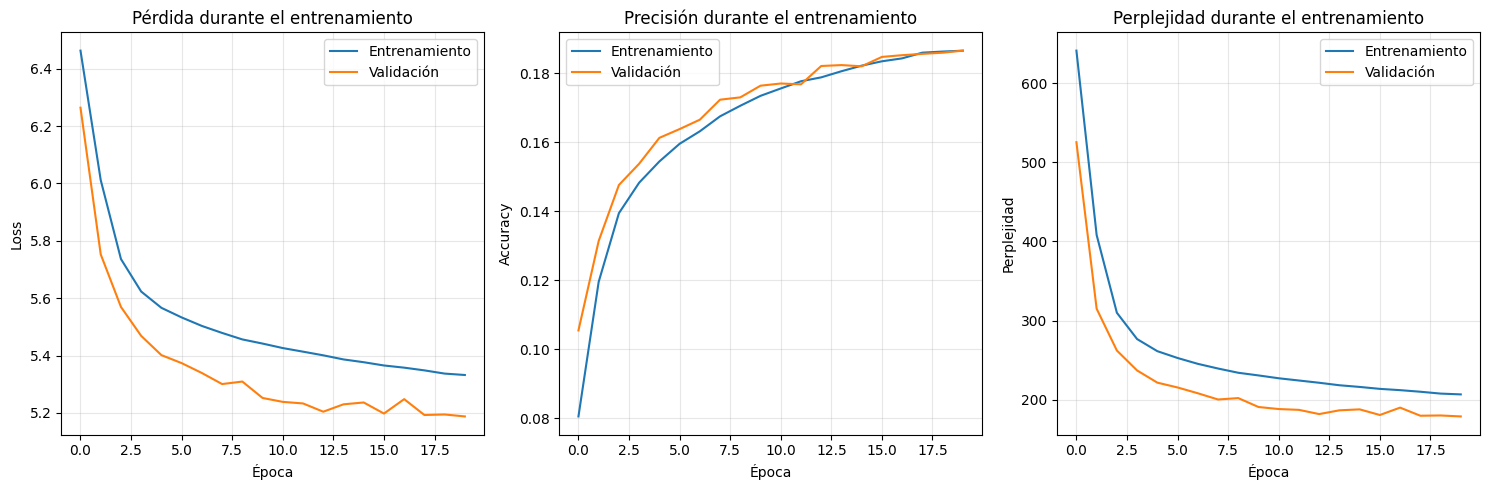

In [19]:
plt.figure(figsize=(15, 5))

# Loss
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Accuracy
plt.subplot(1, 3, 2)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# Perplejidad
plt.subplot(1, 3, 3)
if 'perplexity' in history.history:
    plt.plot(history.history['perplexity'], label='Entrenamiento')
if 'val_perplexity' in history.history:
    plt.plot(history.history['val_perplexity'], label='Validación')
plt.title('Perplejidad durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Perplejidad')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Implementación de Estrategias de Generación

### Funciones de Codificación y Decodificación

In [20]:
def codificar_texto(texto, tokenizer, max_length):
    """Codifica un texto a secuencia numérica"""
    secuencia = tokenizer.texts_to_sequences([texto])[0]
    return pad_sequences([secuencia], maxlen=max_length, padding='pre')[0]

def decodificar_secuencia(secuencia, tokenizer):
    """Decodifica una secuencia numérica a texto"""
    palabras = []
    for token in secuencia:
        if token != 0:  # padding
            palabra = tokenizer.index_word.get(token, '<UNK>')
            palabras.append(palabra)
    return ' '.join(palabras)

def predecir_siguiente_palabra(modelo, secuencia_codificada):
    """Predice la siguiente palabra dada una secuencia"""
    prediccion = modelo.predict(secuencia_codificada.reshape(1, -1), verbose=0)
    return prediccion[0]

# cargar el mejor modelo
try:
    modelo = keras.models.load_model('best_language_model.keras')
    print("✅ Mejor modelo cargado desde entrenamiento")
except:
    print("⚠️ Usando modelo actual del entrenamiento")

def generar_greedy_search(modelo, tokenizer, texto_semilla, num_palabras):
    """
    GREEDY SEARCH: Selecciona siempre la palabra más probable
    """
    texto_generado = texto_semilla
    
    for _ in range(num_palabras):
        secuencia = codificar_texto(texto_generado, tokenizer, max_context_size)
        prediccion = predecir_siguiente_palabra(modelo, secuencia)
        palabra_idx = np.argmax(prediccion)
        if palabra_idx in tokenizer.index_word:
            siguiente_palabra = tokenizer.index_word[palabra_idx]
            texto_generado += ' ' + siguiente_palabra
    
    return texto_generado

def generar_con_temperatura(modelo, tokenizer, texto_semilla, num_palabras, temperatura=1.0):
    """
    GENERACIÓN CON TEMPERATURA: Control de aleatoriedad
    """
    texto_generado = texto_semilla
    
    for _ in range(num_palabras):
        secuencia = codificar_texto(texto_generado, tokenizer, max_context_size)
        prediccion = predecir_siguiente_palabra(modelo, secuencia)
        if temperatura > 0:
            logits = np.log(prediccion + 1e-10)
            prediccion_temp = softmax(logits / temperatura)
            palabra_idx = np.random.choice(len(prediccion_temp), p=prediccion_temp)
        else:
            palabra_idx = np.argmax(prediccion)
        
        if palabra_idx in tokenizer.index_word:
            siguiente_palabra = tokenizer.index_word[palabra_idx]
            texto_generado += ' ' + siguiente_palabra
    
    return texto_generado

✅ Mejor modelo cargado desde entrenamiento


### Greedy Search

In [21]:
def greedy_search(modelo, tokenizer, texto_semilla, max_length, num_palabras):
    """
    Generación usando Greedy Search - siempre selecciona la palabra más probable
    """
    return generar_greedy_search(modelo, tokenizer, texto_semilla, num_palabras)

In [22]:
texto_inicial = "El caso llegó a juicio"
print("=== ESTRATEGIAS DE GENERACIÓN ===")
print(f"🌱 Texto inicial: '{texto_inicial}'")
print()

# GREEDY SEARCH
resultado_greedy = generar_greedy_search(modelo, tokenizer, texto_inicial, 15)
print("🔸 GREEDY SEARCH:")
print(f"   {resultado_greedy}")
print()

# GENERACIÓN CON TEMPERATURA
temperaturas = [0.5, 0.8, 1.0, 1.2, 1.5]
print("🌡️ GENERACIÓN CON TEMPERATURA:")
for temp in temperaturas:
    resultado_temp = generar_con_temperatura(modelo, tokenizer, texto_inicial, 15, temp)
    print(f"   T={temp}: {resultado_temp}")
print()

=== ESTRATEGIAS DE GENERACIÓN ===
🌱 Texto inicial: 'El caso llegó a juicio'

🔸 GREEDY SEARCH:
   El caso llegó a juicio de <UNK> y <UNK> a la <UNK> de la <UNK> de la <UNK> de la

🌡️ GENERACIÓN CON TEMPERATURA:
   T=0.5: El caso llegó a juicio en el <UNK> de la <UNK> de la <UNK> <UNK> de la <UNK> <UNK> que
   T=0.8: El caso llegó a juicio en el encantadora traído <UNK> <UNK> que los <UNK> de la ciudad exhaló a la
   T=1.0: El caso llegó a juicio en cuanto luego dos felices de los <UNK> que se sintieron <UNK> de eso en
   T=1.2: El caso llegó a juicio de toneladas aseguradoras casi media buena diversos saberlo con sin morir admirado a algo voluntarios
   T=1.5: El caso llegó a juicio funerales y fue existía hace años solemne bar despiadado pruebas revolvió detrás de sin objeción



### Beam Search Determinístico


In [23]:
def beam_search_deterministico(modelo, tokenizer, texto_semilla, max_length, num_palabras, beam_width=3):
    """
    BEAM SEARCH DETERMINÍSTICO - Mantiene las mejores secuencias basado en probabilidad
    """
    secuencia_inicial = codificar_texto(texto_semilla, tokenizer, max_length)
    beam = [(secuencia_inicial, 0.0, texto_semilla)]
    
    for _ in range(num_palabras):
        candidatos = []
        
        for secuencia, log_prob, texto in beam:
            prediccion = predecir_siguiente_palabra(modelo, secuencia)
            top_indices = np.argsort(prediccion)[-beam_width*2:]
            
            for idx in top_indices:
                if idx in tokenizer.index_word and prediccion[idx] > 1e-8:
                    palabra = tokenizer.index_word[idx]
                    nueva_prob = log_prob + np.log(prediccion[idx] + 1e-10)
                    
                    nuevo_texto = texto + ' ' + palabra
                    nueva_secuencia = codificar_texto(nuevo_texto, tokenizer, max_length)
                    candidatos.append((nueva_secuencia, nueva_prob, nuevo_texto))
        
        candidatos.sort(key=lambda x: x[1], reverse=True)
        beam = candidatos[:beam_width]
        
        if not beam:
            break
    
    return beam[0][2] if beam else texto_semilla

def select_candidates_beam(predicciones, num_beams, vocab_size, history_probs, mode, temp=1.0):
    """
    Función auxiliar para seleccionar candidatos
    """
    pred_large = []
    
    for idx, pred in enumerate(predicciones):
        pred_large.extend(np.log(pred + 1e-10) + history_probs[idx])
    
    pred_large = np.array(pred_large)
    
    if mode == 'det':
        idx_select = np.argsort(pred_large)[::-1][:num_beams]
    elif mode == 'sto':
        idx_select = np.random.choice(
            np.arange(pred_large.shape[0]), 
            num_beams, 
            p=softmax(pred_large / temp),
            replace=False
        )
    else:
        raise ValueError(f'Modo incorrecto: {mode}. Use "det" o "sto".')
    
    return pred_large[idx_select], idx_select

def beam_search_estocastico(modelo, tokenizer, texto_semilla, max_length, num_palabras, 
                          beam_width=3, temperatura=1.0):
    """
    BEAM SEARCH ESTOCÁSTICO CON TEMPERATURA
    """
    secuencia_inicial = codificar_texto(texto_semilla, tokenizer, max_length)
    
    vocab_size = len(tokenizer.word_index) + 1
    beam = [(secuencia_inicial, 0.0, texto_semilla)]
    
    for _ in range(num_palabras):
        predicciones = []
        
        for secuencia, log_prob, texto in beam:
            pred = predecir_siguiente_palabra(modelo, secuencia)
            predicciones.append(pred)
        
        history_probs = [item[1] for item in beam]
        
        candidatos = []
        for beam_idx, (secuencia, log_prob, texto) in enumerate(beam):
            prediccion = predicciones[beam_idx]
            
            logits = np.log(prediccion + 1e-10)
            logits_temp = logits / temperatura
            probs_temp = softmax(logits_temp)
            
            indices_seleccionados = np.random.choice(
                len(probs_temp),
                size=min(beam_width, len(probs_temp)),
                p=probs_temp,
                replace=False
            )
            
            for idx in indices_seleccionados:
                if idx in tokenizer.index_word:
                    palabra = tokenizer.index_word[idx]
                    nueva_prob = log_prob + np.log(prediccion[idx] + 1e-10)
                    nuevo_texto = texto + ' ' + palabra
                    nueva_secuencia = codificar_texto(nuevo_texto, tokenizer, max_length)
                    candidatos.append((nueva_secuencia, nueva_prob, nuevo_texto))
        
        candidatos.sort(key=lambda x: x[1], reverse=True)
        beam = candidatos[:beam_width]
        
        if not beam:
            break
    
    return beam[0][2] if beam else texto_semilla

# BEAM SEARCH
resultado_beam_det = beam_search_deterministico(modelo, tokenizer, texto_inicial, max_context_size, 15, beam_width=3)
print("🔍 BEAM SEARCH DETERMINÍSTICO:")
print(f"   {resultado_beam_det}")
print()

# BEAM SEARCH ESTOCÁSTICO
print("🎲 BEAM SEARCH ESTOCÁSTICO - EFECTO DE LA TEMPERATURA:")
temperaturas_beam = [0.5, 1.0, 1.5, 2.0]
for temp in temperaturas_beam:
    resultado_beam_sto = beam_search_estocastico(
        modelo, tokenizer, texto_inicial, max_context_size, 15, 
        beam_width=3, temperatura=temp
    )
    print(f"   T={temp}: {resultado_beam_sto}")
print()

🔍 BEAM SEARCH DETERMINÍSTICO:
   El caso llegó a juicio en el <UNK> de la <UNK> <UNK> de <UNK> <UNK> de <UNK> <UNK> de <UNK>

🎲 BEAM SEARCH ESTOCÁSTICO - EFECTO DE LA TEMPERATURA:
   T=0.5: El caso llegó a juicio y <UNK> a los <UNK> de la <UNK> de la <UNK> <UNK> de <UNK> <UNK>
   T=1.0: El caso llegó a juicio y se <UNK> en el <UNK> <UNK> de su <UNK> <UNK> en el <UNK> de
   T=1.5: El caso llegó a juicio del hospital <UNK> a un aventura de casa la familia en <UNK> menos <UNK> <UNK>
   T=2.0: El caso llegó a juicio porque le deseaba hablado mucho siguiente bastante acabar con tío por nosotros gridley era una



### Beam Search Estocástico con Temperatura

In [29]:
def comparar_estrategias_generacion(modelo, tokenizer, semillas, num_palabras=12):
    """
    Comparación sistemática de estrategias
    """
    resultados = {}
    
    for i, semilla in enumerate(semillas, 1):
        print(f"SEMILLA {i}: {semilla}")
        print("-" * 60)
        
        resultados[semilla] = {}
        
        # GREEDY SEARCH
        greedy = generar_greedy_search(modelo, tokenizer, semilla, num_palabras)
        resultados[semilla]['greedy'] = greedy
        print(f"🔸 Greedy Search: {greedy}")
        
        # BEAM SEARCH DETERMINÍSTICO
        beam_det = beam_search_deterministico(modelo, tokenizer, semilla, max_context_size, num_palabras, beam_width=3)
        resultados[semilla]['beam_deterministico'] = beam_det
        print(f"🔍 Beam Determinístico: {beam_det}")
        
        # BEAM SEARCH ESTOCÁSTICO (T=0.8)
        beam_sto_low = beam_search_estocastico(modelo, tokenizer, semilla, max_context_size, num_palabras, beam_width=3, temperatura=0.8)
        resultados[semilla]['beam_estocastico_08'] = beam_sto_low
        print(f"🎲 Beam Estocástico (T=0.8): {beam_sto_low}")
        
        # BEAM SEARCH ESTOCÁSTICO (T=1.5)
        beam_sto_high = beam_search_estocastico(modelo, tokenizer, semilla, max_context_size, num_palabras, beam_width=3, temperatura=1.5)
        resultados[semilla]['beam_estocastico_15'] = beam_sto_high
        print(f"🎲 Beam Estocástico (T=1.5): {beam_sto_high}")
        
        print("\n" + "="*70 + "\n")
    
    return resultados

# Semillas mejoradas - más diversas y representativas del dominio legal
semillas_evaluacion = [
    "El abogado presentó la demanda",
    "La corte declaró culpable al",
    "El juez consideró la evidencia",
    "Los testigos confirmaron que el",
    "La investigación reveló que la",
    "El fiscal argumentó que",
    "La defensa sostuvo que su",
    "El veredicto final fue"
]

print("=== COMPARACIÓN ESTRATEGIAS DE GENERACIÓN (SEMILLAS MEJORADAS) ===\n")
resultados_comparacion = comparar_estrategias_generacion(modelo, tokenizer, semillas_evaluacion)

=== COMPARACIÓN ESTRATEGIAS DE GENERACIÓN (SEMILLAS MEJORADAS) ===

SEMILLA 1: El abogado presentó la demanda
------------------------------------------------------------
🔸 Greedy Search: El abogado presentó la demanda de <UNK> <UNK> de <UNK> <UNK> y <UNK> a la <UNK> de
🔸 Greedy Search: El abogado presentó la demanda de <UNK> <UNK> de <UNK> <UNK> y <UNK> a la <UNK> de
🔍 Beam Determinístico: El abogado presentó la demanda a los <UNK> de la <UNK> de la <UNK> <UNK> de la
🔍 Beam Determinístico: El abogado presentó la demanda a los <UNK> de la <UNK> de la <UNK> <UNK> de la
🎲 Beam Estocástico (T=0.8): El abogado presentó la demanda con la <UNK> <UNK> de los <UNK> de la <UNK> <UNK> de
🎲 Beam Estocástico (T=0.8): El abogado presentó la demanda con la <UNK> <UNK> de los <UNK> de la <UNK> <UNK> de
🎲 Beam Estocástico (T=1.5): El abogado presentó la demanda de ayuda en independencia de el condado de devastadora que no <UNK>


SEMILLA 2: La corte declaró culpable al
--------------------------------

## Evaluación y Comparación de Estrategias


### Generación con Múltiples Semillas


In [30]:
# Semillas ampliadas para evaluación más comprehensiva
semillas = [
    "El abogado presentó la demanda",
    "La corte declaró culpable al", 
    "El juez consideró la evidencia",
    "Los testigos confirmaron que el",
    "La investigación reveló que la",
    "El fiscal argumentó que",
    "La defensa sostuvo que su",
    "El veredicto final fue",
    "El tribunal superior ratificó",
    "La sentencia estableció que"
]

print("=== COMPARACIÓN OPTIMIZADA DE ESTRATEGIAS (EVALUACIÓN EXTENDIDA) ===\n")

for i, semilla in enumerate(semillas, 1):
    print(f"SEMILLA {i}: {semilla}")
    print("-" * 60)
    
    # Greedy Search
    greedy = generar_greedy_search(modelo, tokenizer, semilla, 12)
    print(f"🔸 Greedy: {greedy}")
    
    # Beam Search Determinístico
    beam = beam_search_deterministico(modelo, tokenizer, semilla, max_context_size, 12, beam_width=3)
    print(f"🔍 Beam: {beam}")
    
    # Temperatura balanceada (T=0.8)
    temp_balance = generar_con_temperatura(modelo, tokenizer, semilla, 12, 0.8)
    print(f"🌡️ T=0.8: {temp_balance}")
    
    # Temperatura creativa (T=1.2)
    temp_creativo = generar_con_temperatura(modelo, tokenizer, semilla, 12, 1.2)
    print(f"🎨 T=1.2: {temp_creativo}")
    
    print("\n" + "="*70 + "\n")

=== COMPARACIÓN OPTIMIZADA DE ESTRATEGIAS (EVALUACIÓN EXTENDIDA) ===

SEMILLA 1: El abogado presentó la demanda
------------------------------------------------------------
🔸 Greedy: El abogado presentó la demanda de <UNK> <UNK> de <UNK> <UNK> y <UNK> a la <UNK> de
🔸 Greedy: El abogado presentó la demanda de <UNK> <UNK> de <UNK> <UNK> y <UNK> a la <UNK> de
🔍 Beam: El abogado presentó la demanda a los <UNK> de la <UNK> de la <UNK> <UNK> de la
🔍 Beam: El abogado presentó la demanda a los <UNK> de la <UNK> de la <UNK> <UNK> de la
🌡️ T=0.8: El abogado presentó la demanda y <UNK> un <UNK> puntos de una decisión de tarjetas de duelo
🌡️ T=0.8: El abogado presentó la demanda y <UNK> un <UNK> puntos de una decisión de tarjetas de duelo
🎨 T=1.2: El abogado presentó la demanda de fingió pesaba mal orleans fortier a siempre fuerte al memphis al


SEMILLA 2: La corte declaró culpable al
------------------------------------------------------------
🎨 T=1.2: El abogado presentó la demanda de fingió pe

### Análisis de Diversidad y Coherencia


In [31]:
def calcular_diversidad(textos):
    """Calcula la diversidad lexical de un conjunto de textos"""
    todas_palabras = []
    for texto in textos:
        palabras = texto.lower().split()
        todas_palabras.extend(palabras)
    
    palabras_unicas = set(todas_palabras)
    diversidad = len(palabras_unicas) / len(todas_palabras) if todas_palabras else 0
    return diversidad, len(palabras_unicas), len(todas_palabras)

def generar_multiples_textos(modelo, tokenizer, semilla, estrategia, n_samples=5):
    """Genera múltiples textos con la misma estrategia"""
    textos = []
    
    for _ in range(n_samples):
        if estrategia == 'greedy':
            texto = generar_greedy_search(modelo, tokenizer, semilla, 12)
        elif estrategia == 'beam_det':
            texto = beam_search_deterministico(modelo, tokenizer, semilla, max_context_size, 12)
        elif estrategia == 'beam_sto_low':
            texto = beam_search_estocastico(modelo, tokenizer, semilla, max_context_size, 12, temperatura=0.8)
        elif estrategia == 'beam_sto_high':
            texto = beam_search_estocastico(modelo, tokenizer, semilla, max_context_size, 12, temperatura=1.5)
        
        textos.append(texto)
    
    return textos

In [32]:
# Análisis de diversidad con semilla más representativa
semilla_analisis = "El tribunal decidió que el acusado"
estrategias = ['greedy', 'beam_det', 'beam_sto_low', 'beam_sto_high']
nombres_estrategias = ['Greedy Search', 'Beam Determinístico', 'Beam Estocástico (T=0.8)', 'Beam Estocástico (T=1.5)']

print("=== ANÁLISIS DE DIVERSIDAD LEXICAL ===\n")
print(f"🎯 Semilla de análisis: '{semilla_analisis}'")
print(f"📊 Generando 5 muestras por estrategia...\n")

resultados_diversidad = {}

for estrategia, nombre in zip(estrategias, nombres_estrategias):
    textos = generar_multiples_textos(modelo, tokenizer, semilla_analisis, estrategia)
    diversidad, unicas, total = calcular_diversidad(textos)
    
    resultados_diversidad[nombre] = {
        'diversidad': diversidad,
        'palabras_unicas': unicas,
        'palabras_total': total,
        'textos': textos
    }
    
    print(f"📈 {nombre}:")
    print(f"   • Diversidad lexical: {diversidad:.3f}")
    print(f"   • Palabras únicas: {unicas}")
    print(f"   • Palabras totales: {total}")
    print(f"   • Ratio único/total: {(unicas/total)*100:.1f}%")
    print("   • Ejemplos generados:")
    for i, texto in enumerate(textos[:3], 1):
        print(f"     {i}: {texto}")
    print()

=== ANÁLISIS DE DIVERSIDAD LEXICAL ===

🎯 Semilla de análisis: 'El tribunal decidió que el acusado'
📊 Generando 5 muestras por estrategia...

📈 Greedy Search:
   • Diversidad lexical: 0.111
   • Palabras únicas: 10
   • Palabras totales: 90
   • Ratio único/total: 11.1%
   • Ejemplos generados:
     1: El tribunal decidió que el acusado se <UNK> en el <UNK> de la <UNK> de la <UNK> de
     2: El tribunal decidió que el acusado se <UNK> en el <UNK> de la <UNK> de la <UNK> de
     3: El tribunal decidió que el acusado se <UNK> en el <UNK> de la <UNK> de la <UNK> de

📈 Greedy Search:
   • Diversidad lexical: 0.111
   • Palabras únicas: 10
   • Palabras totales: 90
   • Ratio único/total: 11.1%
   • Ejemplos generados:
     1: El tribunal decidió que el acusado se <UNK> en el <UNK> de la <UNK> de la <UNK> de
     2: El tribunal decidió que el acusado se <UNK> en el <UNK> de la <UNK> de la <UNK> de
     3: El tribunal decidió que el acusado se <UNK> en el <UNK> de la <UNK> de la <UNK> de

📈 

In [33]:
nombres = list(resultados_diversidad.keys())
diversidades = [resultados_diversidad[n]['diversidad'] for n in nombres]

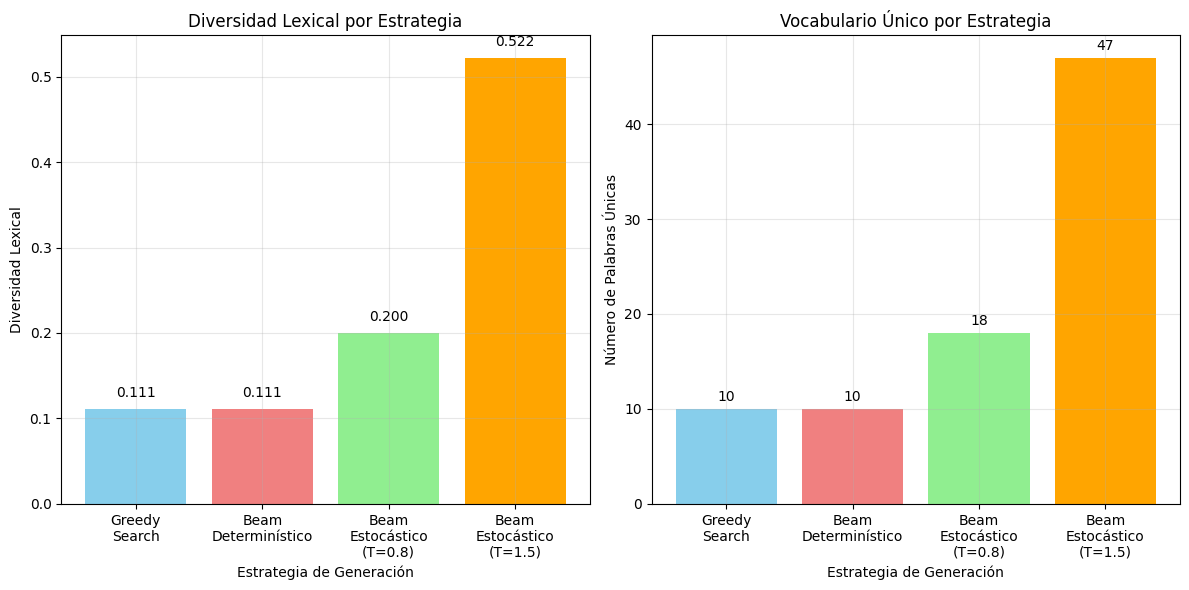

In [34]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
bars = plt.bar(range(len(nombres)), diversidades, color=['skyblue', 'lightcoral', 'lightgreen', 'orange'])
plt.xlabel('Estrategia de Generación')
plt.ylabel('Diversidad Lexical')
plt.title('Diversidad Lexical por Estrategia')
plt.xticks(range(len(nombres)), [n.replace(' ', '\n') for n in nombres], rotation=0)
plt.grid(True, alpha=0.3)

for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{diversidades[i]:.3f}', ha='center', va='bottom')

plt.subplot(1, 2, 2)
palabras_unicas = [resultados_diversidad[n]['palabras_unicas'] for n in nombres]
bars2 = plt.bar(range(len(nombres)), palabras_unicas, color=['skyblue', 'lightcoral', 'lightgreen', 'orange'])
plt.xlabel('Estrategia de Generación')
plt.ylabel('Número de Palabras Únicas')
plt.title('Vocabulario Único por Estrategia')
plt.xticks(range(len(nombres)), [n.replace(' ', '\n') for n in nombres], rotation=0)
plt.grid(True, alpha=0.3)

for i, bar in enumerate(bars2):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{palabras_unicas[i]}', ha='center', va='bottom')

plt.tight_layout()
plt.show()